# **STEP 4**: Preprocess the CT Nifti Volumes

In [3]:
#the python debugger is a library that provides an interactive source code debugger for Python programs
import pdb

import numpy as np
import os
import nibabel as nib
import scipy.misc
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import zipfile
from zipfile import ZipFile

In [10]:
dir = '/notebooks/disk2/RT_Dataset_2/02_Patients_NifTI/Patient_57'

### 4.1 Windowing
###### Also known as grey-level mapping, contrast stretching, histogram modification or contrast enhancement is the process in which the CT image greyscale component of an image is manipulated via the CT numbers, highlighting particular structures.

In [11]:
# Fuction that defines a gray window with a central value and a window, provided to the function
def windowing(image, window_center, window_width):
    img_min = window_center - (window_width // 2)
    img_max = window_center + (window_width // 2)
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max

    return window_image

os.makedirs(dir, exist_ok=True)

In [12]:
# Apply windowing to all CT NifTi Volumes
for folder in os.listdir(dir):
    if "_CT_" in folder or "CT_" in folder:
        folder_path = os.path.join(dir, folder)
        for file in os.listdir(folder_path):
            if file.startswith("P") and file.endswith(".nii.gz"):
                input_volume = os.path.join(dir, folder, file)
                new_name = file.split(".")[0] + "_Windowed.nii.gz"
                print(new_name)
                medical_volume = sitk.ReadImage(input_volume)
                volume = sitk.GetArrayViewFromImage(medical_volume)
                
                brain_windowed_volume = windowing(volume, 40, 80)
                
                windowed_volume = sitk.GetImageFromArray(brain_windowed_volume)
                
                windowed_volume.SetOrigin(medical_volume.GetOrigin())
                windowed_volume.SetDirection(medical_volume.GetDirection())
                windowed_volume.SetSpacing(medical_volume.GetSpacing())
                
                output_volume_name = os.path.join(dir, folder, new_name)
                writer = sitk.ImageFileWriter()
                writer.SetFileName(output_volume_name)
                writer.Execute(windowed_volume)
                
        print(f'Windowing is done for folder {folder}')

P57_CT_1_TRATAMENTO_Windowed.nii.gz
Windowing is done for folder P57_CT_1_TRATAMENTO


### 4.2 Remove Noise 
###### Remove metal frames of the patient's positioning masks

In [5]:
#Dimension the z axis
def resize_z_axis(ct_data, mask_data):

    scale_factor_z = ct_data.shape[2] / mask_data.shape[2]
    print(f"Scale factor z: {scale_factor_z}")
    #print(f"CT dimensions: {ct_data.shape}")
    #print(f"Mask dimensions: {mask_data.shape}")

    if scale_factor_z < 1:
        print("Reducing the mask dimension...")
        mask_data_resized = zoom(mask_data, (1, 1, scale_factor_z), order=0)
    else:
        print("No need to reduce")
        mask_data_resized = mask_data
    
    return mask_data_resized

In [6]:
def load_and_check_images(ct_path, mask_path):
    ct_img = nib.load(ct_path)
    mask_img = nib.load(mask_path)
    
    ct_data = ct_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    print(f"CT dimensions: {ct_data.shape}")
    print(f"Mask dimensions: {mask_data.shape}")
    
    #if ct_data.shape != mask_data.shape:
        #raise ValueError("CT volume and mask volume must have the same dimensions")

# Resize the mask to match the CT shape if needed
    if ct_data.shape != mask_data.shape:
        print("Resizing mask...")
        mask_data_resized = resize_z_axis(mask_data, ct_data)
        print(f"Resized Mask shape: {mask_data_resized.shape}")
    else:
        mask_data_resized = mask_data


    return ct_data, mask_data, ct_img

In [7]:
# Function to visualize one specific slice of both volumes
def visualize_slice(ct_data, mask_data, slice_idx):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("CT Slice")
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Mask Slice")
    plt.imshow(mask_data[:, :, slice_idx], cmap='gray')
    
    plt.show()

In [8]:
# Function to adjst mask orientation in order to align with the CT volume
def adjust_mask_orientation(mask_data):
    mask_data_flipped = np.flip(mask_data, axis=1)  # Flip along the x-axis
    return mask_data_flipped

In [9]:
# Function to set pixels ouside the mask to 0 in the CT volume
def apply_mask_to_ct(ct_data, mask_data):
    masked_ct_data = np.where(mask_data == 0, 0, ct_data)
    return masked_ct_data

In [10]:
# Function to save the CT volume
def save_image(data, ct_img, output_path):
    masked_ct_img = nib.Nifti1Image(data, ct_img.affine, ct_img.header)

    nib.save(masked_ct_img, output_path)

CT path: /notebooks/disk2/RT_Dataset_2/02_Patients_NifTI/Patient_97/P97_CT_1_TRATAMENTO/P97_CT_1_TRATAMENTO_Windowed.nii.gz
Mask path: /notebooks/disk2/RT_Dataset_2/02_Patients_NifTI/Patient_97/P97_CT_1_TRATAMENTO/mask_Skull.nii.gz
CT dimensions: (512, 512, 206)
Mask dimensions: (512, 512, 206)
Scale factor z: 1.0
No need to reduce
Mask dimensions: (512, 512, 206)


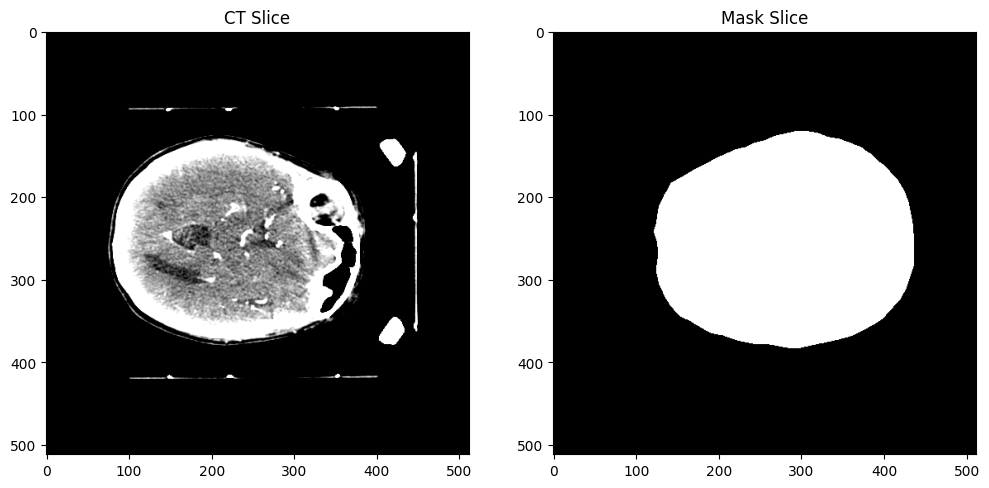

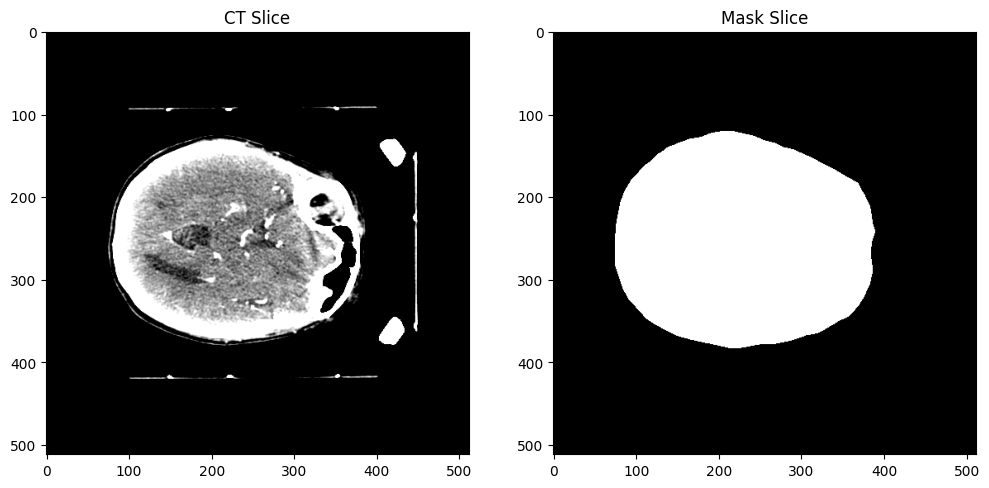

Done for folder: P97_CT_1_TRATAMENTO


In [11]:
# Remove mask frames using Outer_Contour or Skull mask
for folder in os.listdir(dir):
    if "_CT_" in folder:
        folder_path = os.path.join(dir, folder)
        output_file = file.split(".")[0] + "_Windowed.nii.gz"

        for file in os.listdir(folder_path):
            if "_Windowed.nii.gz" in file:
                ct_path = os.path.join(folder_path, file)
                print(f"CT path: {ct_path}")
            elif "Contour.nii.gz" in file:
                mask_path = os.path.join(folder_path, file)
                print(f"Mask path: {mask_path}")
            elif "Skull.nii.gz" in file:
                mask_path = os.path.join(folder_path, file)
                print(f"Mask path: {mask_path}")
            elif "patient.nii.gz" in file:
                mask_path = os.path.join(folder_path, file)
                print(f"Mask path: {mask_path}")
        output_file = folder_path.split("/")[6]
        output_path = os.path.join(folder_path, output_file + "_Windowed_Denoised.nii.gz" )


        ct_data, mask_data, ct_img = load_and_check_images(ct_path, mask_path)

        mask_data_resized = resize_z_axis(ct_data, mask_data)
        print(f"Mask dimensions: {mask_data_resized.shape}")
        
        slice_idx = ct_data.shape[2] // 2
        visualize_slice(ct_data, mask_data_resized, slice_idx)

        mask_data_resized = adjust_mask_orientation(mask_data_resized)

        visualize_slice(ct_data, mask_data_resized, slice_idx)

        masked_ct_data = apply_mask_to_ct(ct_data, mask_data_resized)
        
        save_image(masked_ct_data, ct_img, output_path)

        print(f"Done for folder: {folder}")

### 4.3 Delete Mask in case it is a Patient with missing CT

In [12]:
# Delete Mask in case of patients with missing CT
if dir.split("/")[5].startswith("_"):
    for folder in os.listdir(dir):
        if "_CT_" or "CT_" in folder:
            folder_path = os.path.join(dir, folder)
            for file in os.listdir(folder_path):
                if file.startswith("mask"):
                    file_path = os.path.join(folder_path, file)
                    os.remove(file_path)
            print(f"Files were removed from folder {folder}")